<h1 style="font-size:3rem;color:#A3623B;">Lecture 4: The COMPAS recividism dataset</h1>

## Security and Ethical aspects of data
### Amaya Nogales Gómez

## 1 Introduction

First, we import the original COMPAS dataset used in the Propublica analysis from https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv.

We do the same filtering as in the Propublica analysis and we save our new csv file. For that, we will use R.


In [1]:
# filter dplyr warnings
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%R
library(dplyr)
#You can choose your favorite option:
#a)Download the dataset and access it locally
raw_data <- read.csv("./compas-scores-two-years.csv") 
#b)Access the dataset directly from the repository
raw_data <- read.csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")

nrow(raw_data)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] 7214


Note: if you obtain the following error: "UsageError: Cell magic `%%R` not found."
Try this solution: pip install rpy2


## Filtering of data

<em>In a 2009 study examining the predictive power of its COMPAS score, Northpointe defined recidivism as “a finger-printable arrest involving a charge and a filing for any uniform crime reporting (UCR) code.” We interpreted that to mean a criminal offense that resulted in a jail booking and took place after the crime for which the person was COMPAS scored.

It was not always clear, however, which criminal case was associated with an individual’s COMPAS score. To match COMPAS scores with accompanying cases, we considered cases with arrest dates or charge dates within 30 days of a COMPAS assessment being conducted. In some instances, we could not find any corresponding charges to COMPAS scores. We removed those cases from our analysis.

Next, we sought to determine if a person had been charged with a new crime subsequent to crime for which they were COMPAS screened. We did not count traffic tickets and some municipal ordinance violations as recidivism. We did not count as recidivists people who were arrested for failing to appear at their court hearings, or people who were later charged with a crime that occurred prior to their COMPAS screening.</em>

Finally we save the filtered csv file.



In [3]:
%%R
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count, 
                    days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A')
write.csv(df,"propublica.csv")
nrow(df)


[1] 6172


Now we import the same libraries as in the previous labs.

In [4]:
#we import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # for generating synthetic data 
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

We first read the filtered data. 

In [5]:
df = pd.read_csv("propublica.csv")
df.info()
print("Size of the dataset: %d" % len(df.index)) #We calculate the number of objects in the dataset




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               6172 non-null   int64 
 1   age                      6172 non-null   int64 
 2   c_charge_degree          6172 non-null   object
 3   race                     6172 non-null   object
 4   age_cat                  6172 non-null   object
 5   score_text               6172 non-null   object
 6   sex                      6172 non-null   object
 7   priors_count             6172 non-null   int64 
 8   days_b_screening_arrest  6172 non-null   int64 
 9   decile_score             6172 non-null   int64 
 10  is_recid                 6172 non-null   int64 
 11  two_year_recid           6172 non-null   int64 
 12  c_jail_in                6172 non-null   object
 13  c_jail_out               6172 non-null   object
dtypes: int64(7), object(7)
memory usage: 675

The result reveals a total of 6172 entries in the dataset. From the last column, Dtype, we might observe three different types of variables: the columns with data type “int64” and “float64” denote numerical (integer and real respectively) data while data type “object” denotes categorical data.

We will work with two different datasets. For basic descriptive analysis, we will use "propublica.csv". Later on, in order to obtain different classifiers, we will transform the dataset in order to binarize the categorical features.



Questions:

Do the same preprocessing but for the "compas-scores-two-years-violent.csv" dataset.

1-Load the data, select the variables and filter. Please note that in this dataset, there are 2 renamed variables: $score\_text$ becomes $v\_score\_text$ and $decile\_score$ becomes $v\_decile\_score$.

2-Save it into a new file, "propublica-violent.csv".

3-Which is the size of the dataset before and after filtering?

    

We first observe the different type of variables and the values the take:

In [6]:
for col in df:
    print(df[col].unique())

[   1    2    3 ... 6170 6171 6172]
[69 34 24 44 41 43 39 27 23 37 47 31 25 64 21 32 26 33 30 55 49 29 51 35
 28 53 38 22 62 56 45 40 50 20 36 54 19 42 52 59 61 63 48 46 58 78 57 66
 70 60 65 68 71 83 67 75 72 74 96 73 80 77 76 79 18]
['F' 'M']
['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']
['Greater than 45' '25 - 45' 'Less than 25']
['Low' 'Medium' 'High']
['Male' 'Female']
[ 0  4 14  3  1  7  6  5 13  8  9 21  2 15 10 28 19 11 23 25 36 12 20 33
 16 18 17 22 30 24 27 26 37 29 31 38]
[ -1   0 -20  22  -2 -24 -13 -15 -10 -30  -4 -16 -26  -7  29  -3  23 -11
 -22 -21 -12  -8  -5 -23 -14  -9  -6 -27 -19 -18  26 -29  28   7 -17 -28
   9 -25  13  20  17  30   6   2  16   8   1  18  15  21  27  11   3  14
   5  24]
[ 1  3  4  6 10  5  9  2  7  8]
[0 1]
[0 1]
['2013-08-13 06:03:42' '2013-01-26 03:45:27' '2013-04-13 04:58:34' ...
 '2014-01-13 05:48:01' '2014-03-08 08:06:02' '2014-06-28 12:16:41']
['2013-08-14 05:41:20' '2013-02-05 05:36:53' '2013-04-14 07:02:04'

We do some basic statistic descriptive analysis:

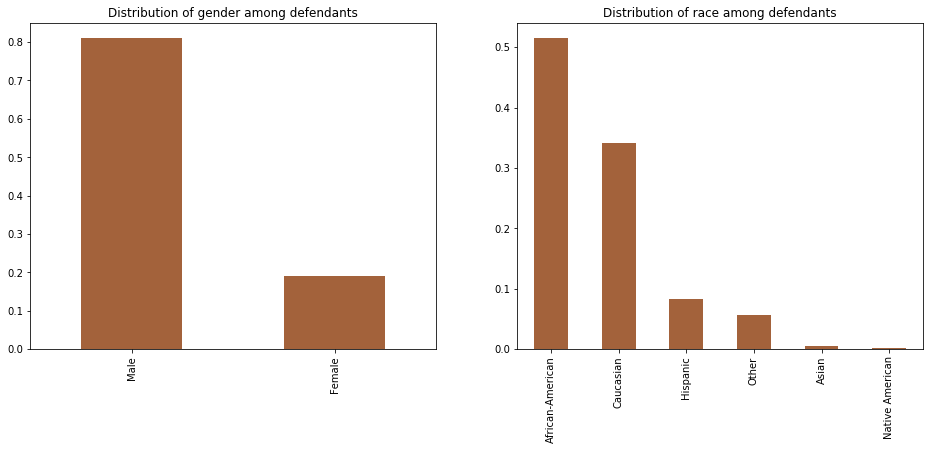

In [7]:
fig, axes = plt.subplots(1,2, figsize=(16,6))

(
    df.sex.value_counts(normalize=True)
    .plot(kind='bar', title='Distribution of gender among defendants', ax=axes[0],color='#A3623B')
)

(
    df.race.value_counts(normalize=True)
    .plot(kind='bar', title='Distribution of race among defendants', ax=axes[1],color='#A3623B')
);


#plt.savefig("Hist_sex_race.pdf")

Questions:

4- Plot the histogram for the $age\_cat$ variable.

5- Plot a pie chart for the $age\_cat$ variable.

Judges are often presented with two sets of scores from the Compas system - one that classifies people into High, Medium and Low risk, and a corresponding decile score. Let us analize this two outputs:

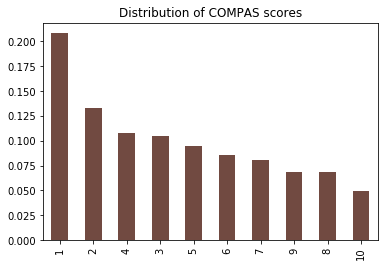

In [8]:
ax=df.decile_score.value_counts(normalize=True).plot(kind='bar', title='Distribution of COMPAS scores', color='#714A41')

#plt.savefig("Hist_score_all.pdf")

Questions:

6-Create a bar chart for the "variable" $score\_text$.

7-Create a bar chart for the compas score ($decile\_score$) for white defendants (caucasian) and black defendants (African-American) separatedly.

8-Repeat question 7 for the $score\_text$.

9-Repeat question 7 for the $sex$.


ProPublica also conducted public records research to determine which defendants re-offended in the two years following their COMPAS screening. They were able to follow up on approximately half the defendants. 

This dataset contains a field $two\_year\_recid$ that is 1 if the defendant re-offended within two years of screening and 0 otherwise. This what we denote $y$, the binary label to be predicted.

We will concern ourselves with comparing the Black and white populations, as in the article. 

Similarly, we will consider a COMPAS score of either 'Medium' or 'High' to be a prediction that the defendant will re-offend within two years, this is what we denote $\hat{y}$, the predicted binary by the COMPAS algorithm.




In [9]:
df = (
    pd.read_csv("propublica.csv")
    #We first binarize the categorical feature c_charge_degree
    .assign(COMPAS_Decision=lambda x:x['score_text'].replace({'Low': 0, 'Medium':1, 'High': 1}))
)



Now we compute the error table:

In [10]:
pd.crosstab(df['COMPAS_Decision'], df['two_year_recid'], margins=True)
 


two_year_recid,0,1,All
COMPAS_Decision,,,
0,2345,1076,3421
1,1018,1733,2751
All,3363,2809,6172


Question: 
    
10- Based on the previous table, which is the False Positive Rate for the COMPAS algorithm? And the False Negative Rate?

11-Which is the accuracy of the COMPAS algorithm in the propublica dataset?

12-Which is the accuracy of the COMPAS algorithm in the propublica-violent dataset?

We are going to visualize with a heatmap the different metrics we want to analyze: the number and rates of false/true negatives/positives:

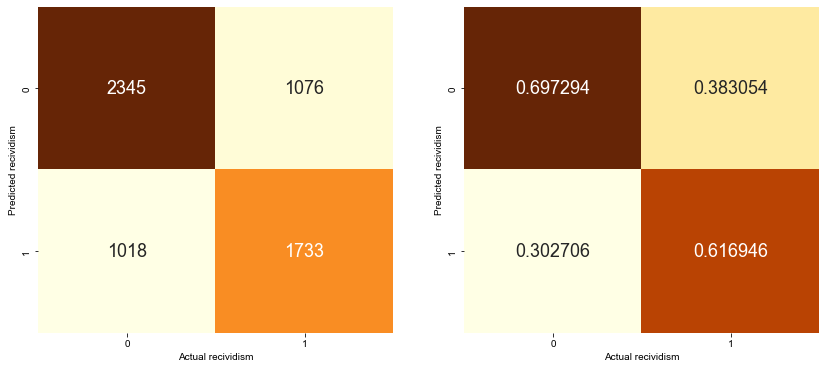

In [11]:
#Warning: we need to normalize by column to obtain the FPR table
cm=pd.crosstab(df['COMPAS_Decision'], df['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'])
cm1=pd.crosstab(df['COMPAS_Decision'], df['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')

fig, axes = plt.subplots(1,2, figsize=(14,6))
(
sns.heatmap(cm,annot=True,fmt="d",cbar=False, ax=axes[0],cmap='YlOrBr', annot_kws={"size":18})
)

(
sns.heatmap(cm1,annot=True,fmt="f",cbar=False,ax=axes[1],cmap='YlOrBr', annot_kws={"size":18})
);
sns.set(font_scale=1.4)
#plt.savefig("FreqTable_all.pdf");

Question:

13-Provide the same tables (heatmaps) for the propublica-violent dataset.

Now we do are going to do the same analysis by race to see if there is any bias:

In [12]:
b_recid = df[df['race'] == 'African-American']
w_recid = df[df['race'] == 'Caucasian']

pd.concat([
    pd.crosstab(b_recid['COMPAS_Decision'], b_recid['two_year_recid'], normalize='columns', margins=False),
    pd.crosstab(w_recid['COMPAS_Decision'], w_recid['two_year_recid'], normalize='columns', margins=False)    
], axis=1, keys=['Black', 'White'])

Black               White         
two_year_recid          0         1         0        1
COMPAS_Decision                                       
0                0.576618  0.284768  0.779859  0.49635
1                0.423382  0.715232  0.220141  0.50365

Question:

14- Which is the accuracy of the COMPAS algorithm for black defendants in the propublica dataset?

15- Which is the accuracy of the COMPAS algorithm for white defendants in the propublica dataset?  

16- Calculate the same table for the propublica-violent dataset.


We are going to visualize with a heatmap the different metrics we want to analyze but this time for black defendants and white defendants separatedly:

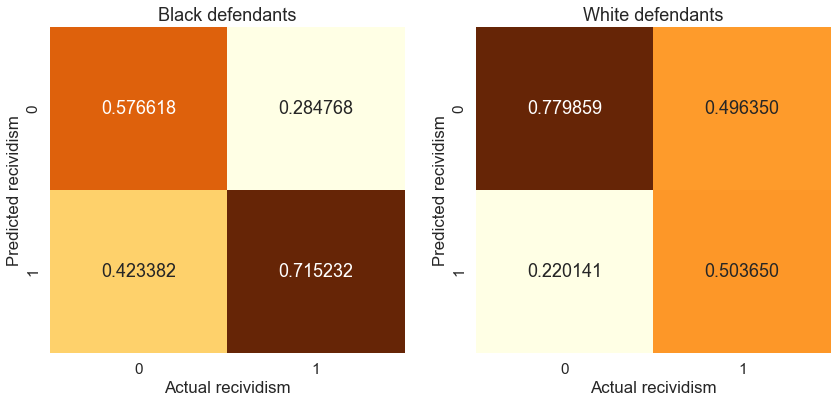

In [13]:
FT_black=pd.crosstab(b_recid['COMPAS_Decision'], b_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')
FT_white=pd.crosstab(w_recid['COMPAS_Decision'], w_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')  

fig, axes = plt.subplots(1,2, figsize=(14,6))
axes[0].set_title('Black defendants',fontsize = 18)
axes[1].set_title('White defendants',fontsize = 18)

(
sns.heatmap(FT_black,annot=True,fmt="f",cbar=False, ax=axes[0],cmap='YlOrBr', annot_kws={"size":18})
)

(
sns.heatmap(FT_white,annot=True,fmt="f",cbar=False,ax=axes[1],cmap='YlOrBr', annot_kws={"size":18})
);
sns.set(font_scale=1.4)

#plt.savefig("FreqTable_BW.pdf")

Question:

17- Provide the same tables for black and white defendants for the propublica-violent dataset. 

18- Which is the accuracy of the COMPAS algorithm for black defendants in the propublica-violent dataset?

19- Which is the accuracy of the COMPAS algorithm for white defendants in the propublica-violent dataset?

Optional question:

20- In the propublica dataset, we justified unfairness in the FNR and FPR differences between black and white defendants. Can we say the same for the propublica-violent dataset? Why?
